In [1]:
!pip install pyautogen
!pip install llama-cpp-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.4/730.4 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.8-cp311-cp311-linux_x86_64.whl size=6008029 sha256=7312fed00cbb71d2eed13402d35b0cbd8d20f363a0474e031d608e698eddefa7
  Stored in directory: /root/.cache/pip/wheels/c0/03/66/eb3810eafd55d921b2be32896d1f44313996982360663aa80b
Successfully built llama-cpp-python


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!mkdir -p /content/models
!wget -O /content/models/mistral-7b-instruct-v0.2.Q4_K_M.gguf \
https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/resolve/main/mistral-7b-instruct-v0.2.Q4_K_M.gguf

--2025-04-07 21:05:11--  https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/resolve/main/mistral-7b-instruct-v0.2.Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 18.164.174.23, 18.164.174.118, 18.164.174.17, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.23|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/72/62/726219e98582d16c24a66629a4dec1b0761b91c918e15dea2625b4293c134a92/3e0039fd0273fcbebb49228943b17831aadd55cbcbf56f0af00499be2040ccf9?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27mistral-7b-instruct-v0.2.Q4_K_M.gguf%3B+filename%3D%22mistral-7b-instruct-v0.2.Q4_K_M.gguf%22%3B&Expires=1744063511&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NDA2MzUxMX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzcyLzYyLzcyNjIxOWU5ODU4MmQxNmMyNGE2NjYyOWE0ZGVjMWIwNzYxYjkxYzkxOGUxNWRlYTI2MjViNDI5M2MxMzRhOTIvM2UwMDM5ZmQwMjczZmNiZWJ

In [4]:
!ls -lh /content/models

total 4.1G
-rw-r--r-- 1 root root 4.1G Dec 11  2023 mistral-7b-instruct-v0.2.Q4_K_M.gguf


In [5]:
from autogen import AssistantAgent, UserProxyAgent, GroupChat, GroupChatManager
from llama_cpp import Llama

In [6]:
# Load the Mistral model
llm = Llama(
    model_path="/content/models/mistral-7b-instruct-v0.2.Q4_K_M.gguf",
    n_ctx=2048,
    n_threads=8,
    n_batch=512,
    verbose=False
)

# Completion wrapper
def llama_completion(prompt: str):
    response = llm(
        prompt,
        stop=["</s>"],           # stop generation cleanly
        max_tokens=512,          # longer responses
        temperature=0.7,
        top_p=0.95,
        repeat_penalty=1.1,
        echo=False
    )
    return response["choices"][0]["text"].strip()


llama_init_from_model: n_ctx_per_seq (2048) < n_ctx_train (32768) -- the full capacity of the model will not be utilized


In [7]:
class AgentWithLogMemory(AssistantAgent):
    def __init__(self, name, system_message, memory_path="/content/conversation_log.txt", window=20):
        super().__init__(name=name, system_message=system_message)
        self.memory_path = memory_path
        self.window = window  # number of last messages to use

    def generate_reply(self, messages, sender, config):
        try:
            with open(self.memory_path, "r") as f:
                all_lines = f.readlines()
                # Keep only the last N lines
                memory_context = "".join(all_lines[-self.window:])
        except FileNotFoundError:
            memory_context = "None"

        full_prompt = (
            f"{self.system_message}\n\n"
            f"Recent discussion context:\n{memory_context}\n\n"
            f"{self.name}, continue with a detailed and helpful contribution."
        )

        print(f"\n📝 Prompt to {self.name}:\n{full_prompt[:500]}...\n")  # Truncate preview

        content = llama_completion(full_prompt)

        return {
            "name": self.name,
            "role": "assistant",
            "content": content
        }

In [8]:
project_manager = AgentWithLogMemory(
    name="ProjectManager",
    system_message="You are a Project Manager. Define milestones, responsibilities, and deliverables."
)

tech_lead = AgentWithLogMemory(
    name="TechnicalLead",
    system_message="You are a Technical Lead. Suggest architecture, tech stack, and dev process."
)

biz_analyst = AgentWithLogMemory(
    name="BusinessAnalyst",
    system_message="You are a Business Analyst. Specify business goals, user needs, and KPIs."
)

#Add agent here to scrutinize results

agents = [project_manager, tech_lead, biz_analyst]

In [9]:
# Clear the log file at the beginning
open("/content/conversation_log.txt", "w").close()

agents = [project_manager, tech_lead, biz_analyst]

initial_message = "We want to build an AI-powered fitness app for seniors. Collaborate and draft a complete project proposal."

# Seed the log with user message
with open("/content/conversation_log.txt", "a") as f:
    f.write(f"User:\n{initial_message}\n\n")

# Run collaboration rounds
max_rounds = 5
for round_num in range(max_rounds):
    print(f"\n🔁 Round {round_num + 1}")
    for agent in agents:
        reply = agent.generate_reply(messages=[], sender="User", config={})  # `messages` not needed
        with open("/content/conversation_log.txt", "a") as f:
            f.write(f"{reply['name']}:\n{reply['content']}\n\n")
        print(f"\n🧠 {reply['name']}:\n{reply['content']}\n")


🔁 Round 1

📝 Prompt to ProjectManager:
You are a Project Manager. Define milestones, responsibilities, and deliverables.

Recent discussion context:
User:
We want to build an AI-powered fitness app for seniors. Collaborate and draft a complete project proposal.



ProjectManager, continue with a detailed and helpful contribution....


🧠 ProjectManager:
Project Manager (PM):
Title: AI-Powered Fitness App for Seniors

1. Project Overview:
Our team aims to develop an innovative, AI-powered fitness app tailored for seniors, enhancing their overall wellbeing and independence by providing personalized workout plans, fall detection, medication reminders, and social connectivity features.

2. Milestones:
  a) Research & Analysis (Weeks 1-4): Define user stories, target audience, market analysis, competitors, and feasibility study.
  b) Design & Development (Weeks 5-16): UX/UI design, app architecture, functionality development, AI integration, and API integrations.
  c) Testing & Quality Assu

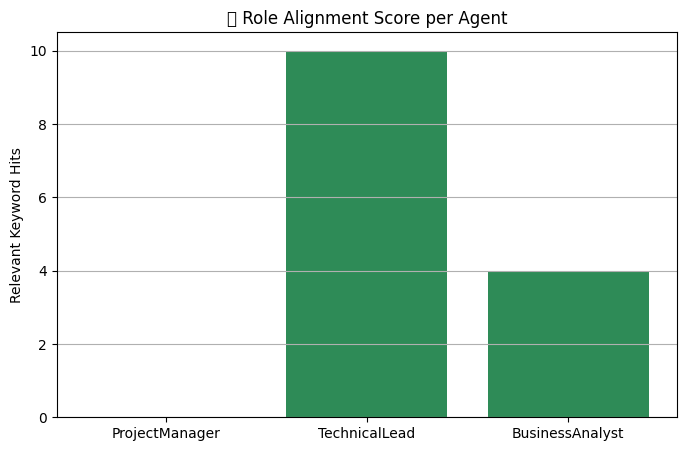

In [11]:
import matplotlib.pyplot as plt
import re

role_keywords = {
    "ProjectManager": ["timeline", "milestone", "schedule", "deliverable"],
    "TechnicalLead": ["architecture", "framework", "API", "database", "tech stack"],
    "BusinessAnalyst": ["user needs", "KPI", "market", "ROI", "requirement"]
}

def evaluate_role_alignment(agent_name, text):
    keywords = role_keywords.get(agent_name, [])
    hits = [kw for kw in keywords if re.search(rf"\b{kw}\b", text.lower())]
    return len(hits)

scores = {agent: 0 for agent in role_keywords}

with open("/content/conversation_log.txt", "r") as f:
    log = f.read()

for agent in scores:
    pattern = rf"{agent}:(.*?)\n\n"
    matches = re.findall(pattern, log, re.DOTALL)
    for reply in matches:
        scores[agent] += evaluate_role_alignment(agent, reply)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(scores.keys(), scores.values(), color='seagreen')
plt.title("🎯 Role Alignment Score per Agent")
plt.ylabel("Relevant Keyword Hits")
plt.grid(axis='y')
plt.show()

In [45]:
# Assuming your `llm` is already defined using llama-cpp

# Manually clean and group valid agent entries
with open("/content/conversation_log.txt", "r") as f:
    log_blocks = f.read().strip().split("\n\n")

valid_entries = [block for block in log_blocks if any(role in block for role in ["ProjectManager:", "TechnicalLead:", "BusinessAnalyst:"])]

# Group every 3 messages as one round
rounds = []
for i in range(0, len(valid_entries), 3):
    round_text = " ".join(valid_entries[i:i+3])
    rounds.append(round_text)

# Prompt + LLM-based topic summarizer
def extract_topics(text):
    prompt = f"""
The following is a transcript from a round of discussion among AI agents collaboratively building a wellness app for seniors. Summarize the key new concepts or topics introduced in this round. Use short phrases and avoid generic terms.

Text:
{text}

Output:
-"""
    response = llm(prompt, stop=["</s>"], max_tokens=256, echo=False)
    return ["- " + line.strip() for line in response["choices"][0]["text"].split("\n") if line.strip()]

# Run extraction for all 5 rounds
for i, round_text in enumerate(rounds):
    print(f"\n🔁 Round {i+1} Topics:")
    for topic in extract_topics(round_text):
        print(topic)


🔁 Round 1 Topics:
- Personalized workout recommendations
- - Progress tracking
- - Gamification elements
- - Scalability
- - Flexibility
- - Real-time data analysis
- - Robust backend infrastructure
- - Efficient algorithms
- - User-friendly visualization tools
- - Customizable workouts for different age groups, fitness levels, or disabilities
- - Integrations with wearables and IoT devices
- AIAssistant:
- AI Assistant (AI):
- **AI Functionality:**
- 1. **Natural Language Processing (NLP):** Implement NLP algorithms to understand user queries, interpret user data, and generate personalized workout plans.
- 2. **Machine Learning (ML) and Deep Learning (DL):** Use ML and DL techniques to analyze user data and generate insights, including identifying trends, making recommendations, and predicting outcomes.
- 3. **Speech Recognition:** Incorporate speech recognition technology to allow users to verbally interact with the application, making it more accessible and user-friendly.
- 4. **Vo

<ipython-input-44-10db9315c800>:55: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


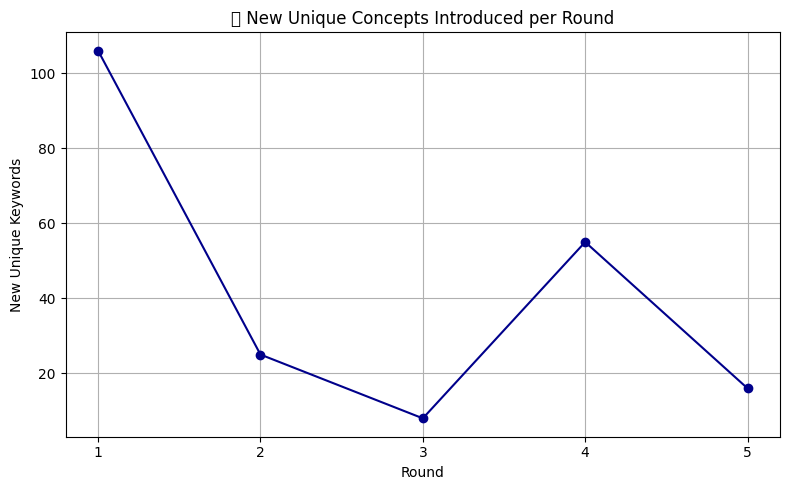

In [44]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

# === Helper: Extract meaningful keywords (min 4 characters)
def extract_keywords(text):
    return set(re.findall(r'\b[a-zA-Z]{4,}\b', text.lower()))

# === Initialize
round_keywords = []
current_round = []
round_size = 3  # ProjectManager, TechnicalLead, BusinessAnalyst

# === Load and process log ===
with open("/content/conversation_log.txt", "r") as f:
    blocks = f.read().strip().split("\n\n")

    for block in blocks:
        if ":" not in block:
            continue
        agent, content = block.split(":", 1)
        agent = agent.strip()
        content = content.strip()

        # Only consider agent entries (exclude User, Summarizer, etc.)
        if agent not in ["ProjectManager", "TechnicalLead", "BusinessAnalyst"]:
            continue

        current_round.append(content)

        # When 3 agents have spoken → new round
        if len(current_round) == round_size:
            combined_text = " ".join(current_round)
            round_keywords.append(extract_keywords(combined_text))
            current_round = []

# === Track new concepts introduced each round ===
new_concepts = []
for i, current_set in enumerate(round_keywords):
    if i == 0:
        new_concepts.append(len(current_set))
    else:
        cumulative_previous = set.union(*round_keywords[:i])
        new = current_set - cumulative_previous
        new_concepts.append(len(new))

# === Plotting ===
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(new_concepts) + 1), new_concepts, marker="o", color="darkblue")
plt.title("🧠 New Unique Concepts Introduced per Round")
plt.xlabel("Round")
plt.ylabel("New Unique Keywords")
plt.xticks(range(1, len(new_concepts) + 1))
plt.grid(True)
plt.tight_layout()
plt.show()